In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', None)
from plotnine import *
from tqdm import tqdm
from joblib import Parallel, delayed # for parallel processing
import statsmodels.formula.api as smf

In [16]:
def dgp(n=2000, p=10, linear=True, constant=True):
        
    Xmat = np.random.multivariate_normal(np.zeros(p), np.eye(p), size=n).astype('float32')

    T = np.random.binomial(1, 0.5, n).astype('int8')

    col_list = ['X' + str(x) for x in range(1,(p+1))]

    df = pd.DataFrame(Xmat, columns = col_list)
    
    # functional form of the covariates
    if linear:
        B = 225 + 50*df['X1'] + 5*df['X2'] + 20*(df['X3']-0.5) + 10*df['X4'] + 5*df['X5']
    else:
        B = 225 + 50*df['X1'] + 5*np.sin(np.pi*df['X1']*df['X2'] ) + 10*(df['X3']-0.5)**2 + 10*df['X4']**2 + 5*df['X5']**3
    
    # constant ate or non-constant
    tau = 5 if constant else 5*df['X1'] + 5*np.log(1 + np.exp(df['X2']))
    
    Y = (B + tau*T + np.random.normal(0,25,n)).astype('float32')
        
    df['T'] = T
    df['Y'] = Y    
    return df

## Set Up Experiment

In [19]:
%%time
import warnings
warnings.filterwarnings("ignore") 
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold

def mlpredict(dfml,p):
    XGB_reg = XGBRegressor(learning_rate = 0.1, 
                            max_depth = 6, 
                            n_estimators = 500, 
                            reg_lambda = 1)

    X_mat = dfml.columns.tolist()[0:p]
    
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

    ix = []
    Yhat = []
    for train_index, test_index in kfold.split(dfml, dfml["T"]):
        
        df_train = dfml.iloc[train_index].reset_index()
        df_test = dfml.iloc[test_index].reset_index()

        X_train = df_train[X_mat].copy()
        y_train = df_train['Y'].copy()
        X_test =  df_test[X_mat].copy()
        XGB_reg.fit(X_train, y_train)

        Y_hat = XGB_reg.predict(X_test)

        ix.extend(list(test_index))
        Yhat.extend(list(Y_hat))

    df_ml = pd.DataFrame({'ix':ix,'Yhat':Yhat}).sort_values(by='ix').reset_index(drop=True)
    df_ml[['Y','T']] = dfml[['Y','T']]
    df_ml['Ytilde'] = df_ml['Yhat'] - np.mean(df_ml['Yhat'])
    df_ml['Yres'] = df_ml['Y'] - df_ml['Yhat']
    df_ml = df_ml.drop('ix', axis=1)

    return df_ml

CPU times: user 111 µs, sys: 33 µs, total: 144 µs
Wall time: 180 µs


In [26]:
def experiment(**kwargs):
    
    dct = {}
    
    n = kwargs['n']
    p = kwargs['p']
    linear = kwargs['linear']
    constant = kwargs['constant']
    
    df = dgp(n,p,linear,constant)
    
    #1. Difference-in-means
    mu_treated = np.mean(df.query('T==1')['Y'])
    mu_control = np.mean(df.query('T==0')['Y'])
    
    dct['DIM'] = mu_treated - mu_control
    
    #2. OLS adjusted
    if kwargs['OLS_adj']:
        
        ols_adj = smf.ols('Y ~' + ('+').join(df.columns.tolist()[0:(p+1)]),
                 data = df).fit(cov_type='HC1',use_t=True)

        dct['OLS_adj'] = ols_adj.params['T']
    
    #3. OLS interacted
    if kwargs['OLS_int']:
        df = df.assign(**({c+'tilde': (df[c] - df[c].mean()) for c in df.columns.tolist()[0:p]}))
    
        ols_int = smf.ols('Y ~' + ('+').join(df.columns.tolist()[0:(p+1)]) + '+' + 'T:('+('+').join(df.columns.tolist()[p+2:])+')',
                 data = df).fit(cov_type='HC1',use_t=True)

        dct['OLS_int'] = ols_int.params['T']
    
    #4. CUPED: Single Covariate 
    if kwargs['CUPED']:
        theta = smf.ols('Y ~ X1',data = df).fit(cov_type='HC1',use_t=True).params['X1']

        df['Y_res'] = df['Y'] - theta*(df['X1'] - np.mean(df['X1']))
        
        cuped = smf.ols('Y_res ~ T', data=df).fit(cov_type='HC1',use_t=True)

        dct['CUPED'] = cuped.params['T']
        
    pred_df = mlpredict(df,p)
    

    #5. Difference-in-differences
    if kwargs['DID']:
        mu2_treated = np.mean(pred_df.query('T==1')['Yres'])
        mu2_control = np.mean(pred_df.query('T==0')['Yres'])

        dct['DID'] = mu2_treated - mu2_control

    #6. MLRATE
    if kwargs['MLRATE']:
        mlrate =  smf.ols('Y ~ T + Yhat + T:Ytilde',
                     data = pred_df).fit(cov_type='HC1',use_t=True)

        dct['MLRATE'] = mlrate.params['T']
    
    return dct
    

In [6]:
def plot_experiment(results, constant = True ):
    
    results_long = pd.melt(results, value_vars=results.columns.tolist() )
    
    print(round(results_long.groupby('variable').agg(mean=("value", "mean"), std=("value", "std"))
          .reset_index().sort_values(by='std', ascending=False).reset_index(drop=True)
          .assign(CI_lower= lambda x: x['mean'] - x['std']*1.96,
                CI_upper= lambda x: x['mean'] + x['std']*1.96,),3)
         )
        
    mu = 5 if constant else 4
    
    p = (ggplot(results_long, aes(x='value',color='variable') ) + 
     geom_density(size=1 )+
     scale_color_manual(values = ['black', 'blue', 'green', 'c','red', 'salmon', 'magenta' ]) + 
     geom_vline(xintercept=mu, colour='black', linetype='dashed' ) + 
     annotate("text", x=mu, y=.1, label="True Mean", size=15)+
     labs(color='Method')  +
     xlab('Estimate') +
     theme(figure_size=(10, 8))
    )
    
    print(p)

## Linear Effects of Covariates & Constant Treatment Effect

100%|███████████████████████████████████████| 1000/1000 [01:29<00:00, 11.24it/s]


  variable   mean    std  CI_lower  CI_upper
0      DIM  5.099  2.730    -0.252    10.450
1    CUPED  5.034  1.530     2.035     8.033
2      DID  5.009  1.276     2.509     7.510
3   MLRATE  5.012  1.276     2.512     7.513
4  OLS_int  4.995  1.121     2.799     7.191
5  OLS_adj  4.995  1.120     2.799     7.191


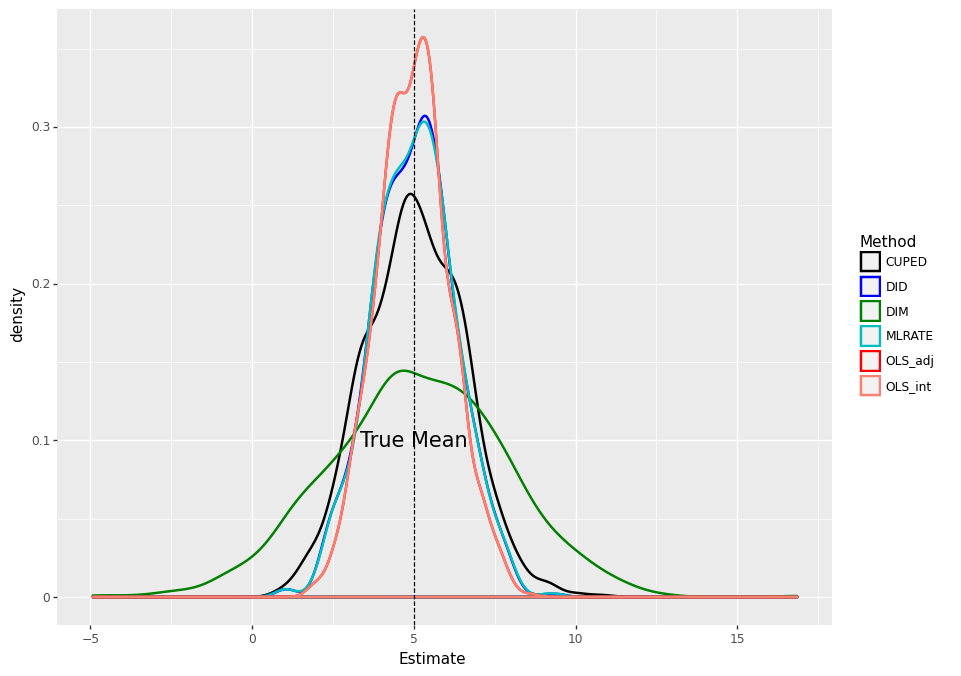


CPU times: user 5.6 s, sys: 866 ms, total: 6.46 s
Wall time: 1min 30s


In [27]:
%%time
tqdm._instances.clear() 
sim = 1000

results1 = Parallel(n_jobs=8)(delayed(experiment)(n=2000, p=10, linear=True, constant=True,
                                    OLS_adj=True, OLS_int=True, CUPED=True, DID=True, MLRATE=True)\
                                    for _ in tqdm(range(sim)) )

results_df1 = pd.DataFrame(results1)

plot_experiment(results_df1)    

## Linear Effects of Covariates & Varying Treatment Effect

100%|███████████████████████████████████████| 1000/1000 [01:28<00:00, 11.25it/s]


  variable   mean    std  CI_lower  CI_upper
0      DIM  4.037  2.830    -1.511     9.584
1    CUPED  4.078  1.571     0.999     7.158
2      DID  4.045  1.273     1.549     6.541
3   MLRATE  4.047  1.271     1.556     6.538
4  OLS_int  4.069  1.122     1.870     6.268
5  OLS_adj  4.069  1.122     1.870     6.268


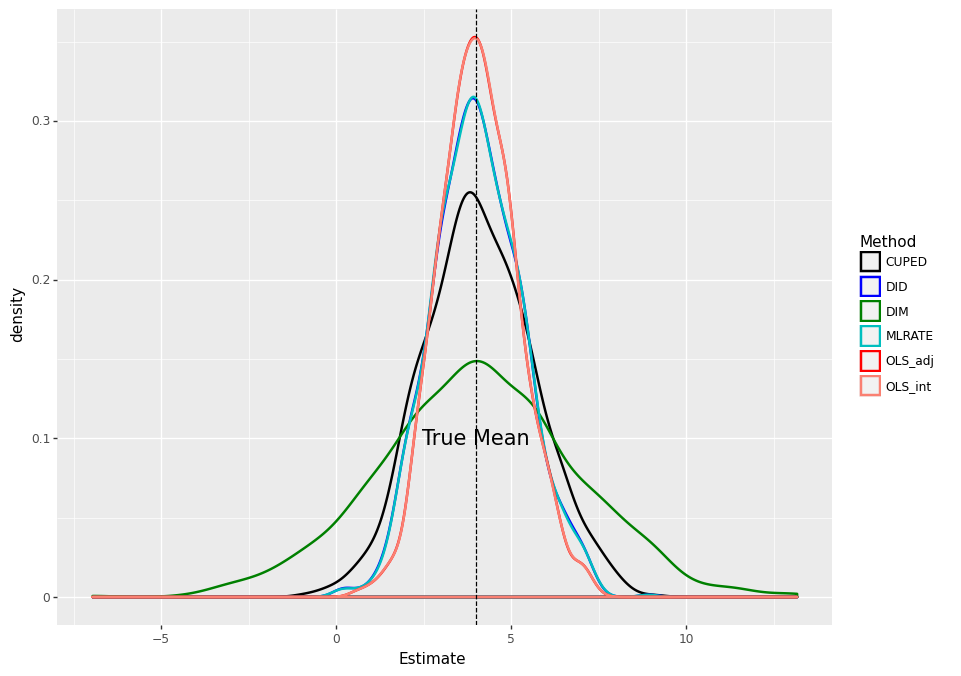


CPU times: user 6.11 s, sys: 265 ms, total: 6.38 s
Wall time: 1min 30s


In [28]:
%%time
tqdm._instances.clear() 
sim = 1000

results2 = Parallel(n_jobs=8)(delayed(experiment)(n=2000, p=10,linear=True, constant=False,
                                    OLS_adj=True, OLS_int=True, CUPED=True, DID=True, MLRATE=True)\
                                    for _ in tqdm(range(sim)) )

results_df2 = pd.DataFrame(results2)

plot_experiment(results_df2, False)    

## Non-Linear Effects of Covariates & Constant Treatment Effect

100%|███████████████████████████████████████| 1000/1000 [01:27<00:00, 11.39it/s]


  variable   mean    std  CI_lower  CI_upper
0      DIM  4.988  2.797    -0.495    10.471
1    CUPED  4.952  1.716     1.588     8.316
2  OLS_int  4.936  1.522     1.954     7.918
3  OLS_adj  4.936  1.521     1.955     7.916
4   MLRATE  4.963  1.376     2.266     7.659
5      DID  4.960  1.374     2.267     7.653


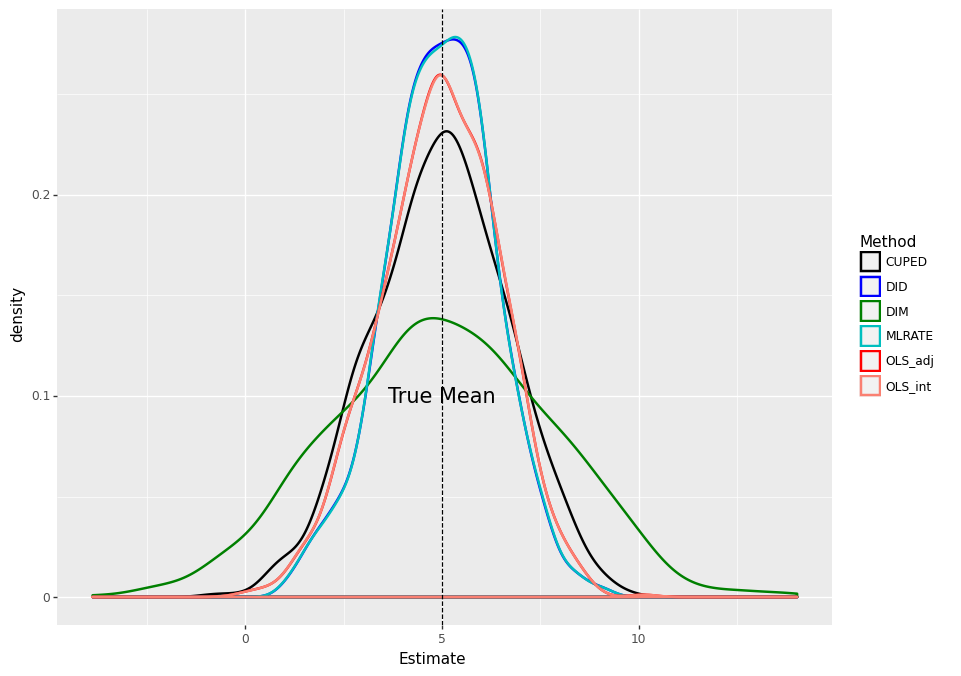


CPU times: user 5.52 s, sys: 261 ms, total: 5.78 s
Wall time: 1min 29s


In [29]:
%%time
tqdm._instances.clear() 
sim = 1000

results3 = Parallel(n_jobs=8)(delayed(experiment)(n=2000, p=10,linear=False, constant=True,
                                    OLS_adj=True, OLS_int=True, CUPED=True, DID=True, MLRATE=True)\
                                    for _ in tqdm(range(sim)) )

results_df3 = pd.DataFrame(results3)

plot_experiment(results_df3)    

## Non-Linear Effects of Covariates & Varying Treatment Effect

100%|███████████████████████████████████████| 1000/1000 [01:27<00:00, 11.48it/s]


  variable   mean    std  CI_lower  CI_upper
0      DIM  4.225  3.012    -1.679    10.128
1    CUPED  4.141  1.821     0.572     7.711
2  OLS_int  4.130  1.625     0.945     7.314
3  OLS_adj  4.129  1.623     0.948     7.311
4      DID  4.144  1.416     1.368     6.920
5   MLRATE  4.146  1.416     1.370     6.922


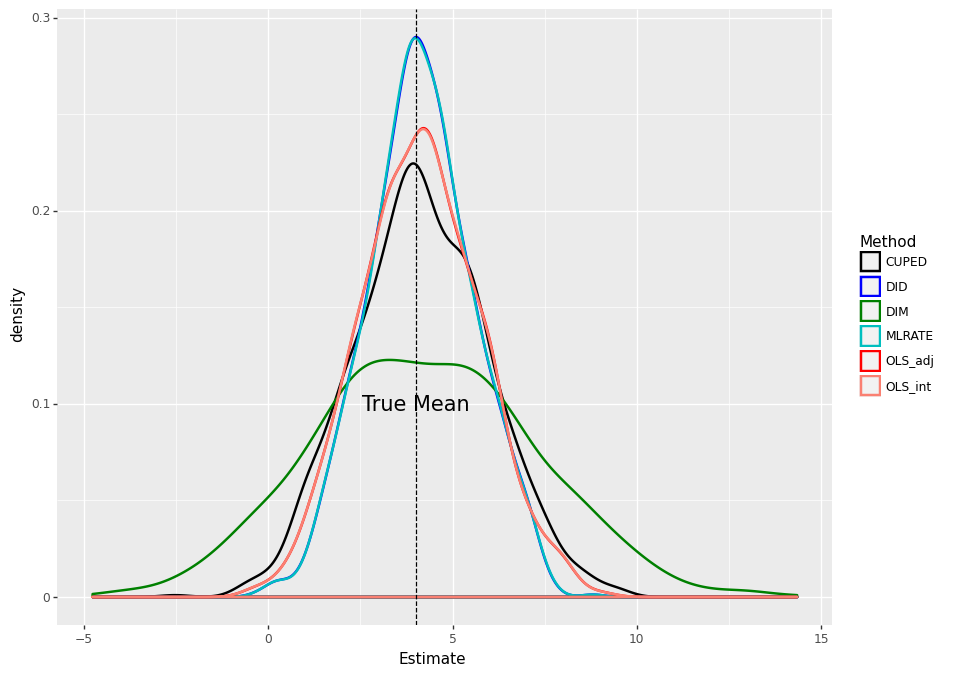


CPU times: user 6.25 s, sys: 249 ms, total: 6.5 s
Wall time: 1min 28s


In [30]:
%%time
tqdm._instances.clear() 
sim = 1000

results4 = Parallel(n_jobs=8)(delayed(experiment)(n=2000, p=10,linear=False, constant=False,
                             OLS_adj=True, OLS_int=True, CUPED=True, DID=True,MLRATE=True)\
                             for _ in tqdm(range(sim)) )

results_df4 = pd.DataFrame(results4)

plot_experiment(results_df4, False)    